# Imports, Helper Functions, and Loading

In [27]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp

import lsst.daf.butler as dafButler
# if you are running latest daily, May 13 (setup lsst_distrib -t d_latest) you should have analysis_ap
# within lsst_distrib

# it was merged as  this ticket 
# https://rubinobs.atlassian.net/browse/DM-44157 
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.set_loglevel('WARNING')

In [28]:
repo = '/repo/embargo'
instrument = 'LSSTComCamSim'
collections = 'u/elhoward/DM-44138/LSSTComCamSim'
schema =  f'elhoward_dm44138_LSSTComCamSim'

butler = dafButler.Butler(repo, instrument=instrument)
registry = butler.registry
skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

In [29]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'elhoward_dm44138_LSSTComCamSim' AND table_name = 'DiaSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())

Available columns: ['diaSourceId', 'visit', 'detector', 'diaObjectId', 'ssObjectId', 'parentDiaSourceId', 'ssObjectReassocTime', 'midpointMjdTai', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'x', 'xErr', 'y', 'yErr', 'x_y_Cov', 'centroid_flag', 'apFlux', 'apFluxErr', 'apFlux_flag', 'apFlux_flag_apertureTruncated', 'snr', 'psfFlux', 'psfFluxErr', 'psfRa', 'psfRaErr', 'psfDec', 'psfDecErr', 'psfFlux_psfRa_Cov', 'psfFlux_psfDec_Cov', 'psfRa_psfDec_Cov', 'psfLnL', 'psfChi2', 'psfNdata', 'psfFlux_flag', 'psfFlux_flag_edge', 'psfFlux_flag_noGoodPixels', 'trailFlux', 'trailFluxErr', 'trailRa', 'trailRaErr', 'trailDec', 'trailDecErr', 'trailLength', 'trailLengthErr', 'trailAngle', 'trailAngleErr', 'trailFlux_trailRa_Cov', 'trailFlux_trailDec_Cov', 'trailFlux_trailLength_Cov', 'trailFlux_trailAngle_Cov', 'trailRa_trailDec_Cov', 'trailRa_trailLength_Cov', 'trailRa_trailAngle_Cov', 'trailDec_trailLength_Cov', 'trailDec_trailAngle_Cov', 'trailLength_trailAngle_Cov', 'trailLnL', 'trailChi2', 'tra

In [30]:
# just a small cell showing number of observations in different parts of the sky

## Grouping tracts based on location on the sky
group1 = [3384, 3385]
group2 = [2261, 2262, 2494, 2495]
group3 = [9880, 9881, 9638]
group4 = [3533, 3534, 3345, 3346]
group5 = [7683, 7684, 7445, 7446]
group6 = [9590, 9591, 9347, 9348]
group7 = [9812, 9813]
group8 = [7149, 6914, 6915]

groups = [group1, group2, group3, group4, group5, group6, group7, group8]

def getUniqueVisits(collections, tracts):
    """Get the unique visits from a given tract."""
    visitList = []
    tracts = ','.join(str(tract) for tract in tracts)
    for d in sorted(registry.queryDatasets(datasetType="goodSeeingDiff_diaSrcTable", collections=collections, \
        where=f"skymap='ops_rehersal_prep_2k_v1' AND tract IN ({tracts})")): 
        visitList.append(d.dataId['visit'])
    uniqueVisits = list(set(visitList))
    return uniqueVisits

visitListByGroup = []

for group in groups:
    visits = getUniqueVisits(collections, group)
    visitListByGroup.append(visits)
    print("There are "+str(len(visits))+f" visits in tracts {group}")

There are 119 visits in tracts [3384, 3385]
There are 352 visits in tracts [2261, 2262, 2494, 2495]
There are 298 visits in tracts [9880, 9881, 9638]
There are 295 visits in tracts [3533, 3534, 3345, 3346]
There are 354 visits in tracts [7683, 7684, 7445, 7446]
There are 238 visits in tracts [9590, 9591, 9347, 9348]
There are 356 visits in tracts [9812, 9813]
There are 299 visits in tracts [7149, 6914, 6915]


In [31]:
# let us look at one tract, just randomly 3533
tract_id = 3533

tractInfo = skymap.generateTract(tract_id)
tractInfo_vertices = tractInfo.vertex_list

vertices_as_deg = []
for i in range(0,4):
   vertices_as_deg.append([tractInfo_vertices[i].getRa().asDegrees(), tractInfo_vertices[i].getDec().asDegrees()])
vertices_as_deg = np.array(vertices_as_deg)

ra_min = np.min(vertices_as_deg[:,0])
ra_max = np.max(vertices_as_deg[:,0])
dec_min = np.min(vertices_as_deg[:,1])
dec_max = np.max(vertices_as_deg[:,1])

In [32]:
# let us say that we want to get all diaSources and diaObjects from this one tract
with apdbQuery.connection as connection:
    pp_source_table = pd.read_sql_query(f'SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai", \
        "visit", "detector", \
        "psfFlux", "psfFluxErr", \
        "scienceFlux", "scienceFluxErr", "snr", \
        "band", "time_processed", "time_withdrawn"  \
        FROM "{schema}"."DiaSource" \
        WHERE "ra" BETWEEN {ra_min} AND {ra_max} \
        AND "dec" BETWEEN {dec_min} AND {dec_max} \
        LIMIT 3000000; ''', connection)
  

with apdbQuery.connection as connection:
    pp_object_table = pd.read_sql_query(f'''SELECT "diaObjectId", "ra", "dec", "nDiaSources", \
        "validityStart", "validityEnd", "lastNonForcedSource"
        FROM "{schema}"."DiaObject"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        AND "validityEnd" IS NULL
        LIMIT 2000000;
        ''', connection)
    
# assert that you got all of them, i.e., that the length of the outpus is lower than the limit requested
assert (len(pp_source_table)) < 3000000
assert (len(pp_object_table)) < 2000000

# Single visit analysis

In [33]:
visit = 7024040300256
detector = 2

src_single_visit_det = pp_source_table[(pp_source_table['visit']==visit) & (pp_source_table['detector']==2)]
# let us store time of the observation for the future
midpointMjdTai = src_single_visit_det['midpointMjdTai'].values[0]
# and print out
src_single_visit_det

,diaSourceId,diaObjectId,ra,dec,midpointMjdTai,visit,detector,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,band,time_processed,time_withdrawn
604299,3065473877497872385,3065473977347473414,224.494751,-39.732911,60404.126433,7024040300256,2,2835.331431,429.856774,32524.484302,421.798633,6.603817,i,2024-05-09 22:54:25.157088,None
604300,3065473877497872393,3065509263725035775,224.501755,-39.700166,60404.126433,7024040300256,2,5426.131143,416.085242,11815.830325,406.881599,12.925547,i,2024-05-09 22:54:25.157088,None
604301,3065473877497872394,3065473885005677179,224.508631,-39.644925,60404.126433,7024040300256,2,32328.547487,544.716646,105129.108768,531.449156,59.235367,i,2024-05-09 22:54:25.157088,None
604302,3065473877497872395,3065473977347473488,224.498020,-39.743690,60404.126433,7024040300256,2,8737.833088,834.298773,590666.484891,824.507332,10.802836,i,2024-05-09 22:54:25.157088,None
604303,3065473877497872396,3065473885005677001,224.514291,-39.603981,60404.126433,7024040300256,2,12130.851493,1125.148589,858428.401458,1101.792368,10.309156,i,2024-05-09 22:54:25.157088,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605806,3065473877497873208,3065473877497873208,224.780908,-39.723138,60404.126433,7024040300256,2,-2327.128949,404.603038,32.186374,398.843269,5.868065,i,2024-05-09 22:54:25.157088,None
605807,3065473877497873209,3065473877497873209,224.784618,-39.708849,60404.126433,7024040300256,2,3083.941218,414.610266,30021.205829,408.924440,7.133037,i,2024-05-09 22:54:25.157088,None
605808,3065473877497873214,3065473877497873214,224.784525,-39.704591,60404.126433,7024040300256,2,2033.548077,406.053691,12636.030202,400.270945,5.263713,i,2024-05-09 22:54:25.157088,None
605809,3065473877497873215,3065473877497873215,224.787439,-39.684022,60404.126433,7024040300256,2,-2362.344956,400.258752,2046.339082,394.221112,6.532410,i,2024-05-09 22:54:25.157088,None


In [34]:
# this is to figure out which healpy corresponds to the observations
# figure out the center of the observations
ra_cent = np.median(src_single_visit_det['ra'])
dec_cent = np.median(src_single_visit_det['dec'])
vec = hp.ang2vec(np.deg2rad((np.abs(dec_cent) + 90)), np.deg2rad(ra_cent))
# from this you can get closet healpixels
ipix_disc = hp.query_disc(nside=32, vec=vec, radius=np.radians(1) )
# take the first value if there are more pixels found nearby 
healpix_id = ipix_disc[0]

In [35]:
# loading truth catalogs here 

# path to the truth catalogs
path_to_tru_cat = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-3/imSim_catalogs/skyCatalogs/'

# loads stars, galaxies, solar system objects
df_single_ps = pd.read_parquet(path_to_tru_cat+'pointsource_'+str(healpix_id)+'.parquet')
df_single_sso = pd.read_parquet(path_to_tru_cat+'sso_'+str(healpix_id)+'.parquet')
df_single_gal = pd.read_parquet(path_to_tru_cat+'galaxy_'+str(healpix_id)+'.parquet')
# for galaxies you have to add 360 to ra because it seems to be from -180 to 180
# and others are 0 to 360
if np.median(df_single_gal['ra']) < 0: 
    df_single_gal['ra'] = df_single_gal['ra'] + 360

# find variable objects (only stars are variable in this rehersal)
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]
df_single_ps_no_var = df_single_ps[df_single_ps['is_variable']==False]

# let us find the max and min extent of the visit
ra_min = np.min(src_single_visit_det['ra'])
ra_max = np.max(src_single_visit_det['ra'])
dec_min = np.min(src_single_visit_det['dec'])
dec_max = np.max(src_single_visit_det['dec'])


# cut the simulated objectd to the area that overlaps
df_single_ps_var_zoom = df_single_ps_var[(df_single_ps_var['ra']<ra_max) & (df_single_ps_var['ra']>ra_min) &\
    (df_single_ps_var['dec']<dec_max) & (df_single_ps_var['dec']>dec_min) ]
df_single_ps_no_var_zoom = df_single_ps_no_var[(df_single_ps_no_var['ra']<ra_max) & (df_single_ps_no_var['ra']>ra_min) &\
    (df_single_ps_no_var['dec']<dec_max) & (df_single_ps_no_var['dec']>dec_min) ]
df_single_gal_zoom = df_single_gal[(df_single_gal['ra']<ra_max) & (df_single_gal['ra']>ra_min) &\
    (df_single_gal['dec']<dec_max) & (df_single_gal['dec']>dec_min) ]

# for solar system we need more work, to get their exact positions during the observations
# this is very ineficent code
sso_ids = np.unique(df_single_sso['id'])
list_of_sso_single_exp = []
for i in range(len(sso_ids)):
    # for object, find all positions, fit as a position of the time and return
    df_single_sso_single_id = df_single_sso[df_single_sso['id']==sso_ids[i]]
    ra_fit = np.polyfit(df_single_sso_single_id['mjd'],df_single_sso_single_id['ra'], deg = 2)
    dec_fit = np.polyfit(df_single_sso_single_id['mjd'],df_single_sso_single_id['dec'], deg = 2)
    ra_poly = np.poly1d(ra_fit)
    dec_poly = np.poly1d(dec_fit)

    # Predicting values
    predicted_ra = ra_poly(midpointMjdTai)
    predicted_dec = dec_poly(midpointMjdTai)
    list_of_sso_single_exp.append([sso_ids[i], predicted_ra, predicted_dec])
    
array_of_sso_single_exp = np.array(list_of_sso_single_exp)
df_single_sso = pd.DataFrame(array_of_sso_single_exp, columns=['id', 'ra', 'dec'])
df_single_sso['ra'] = df_single_sso['ra'].astype(float)
df_single_sso['dec'] = df_single_sso['dec'].astype(float)    
    
df_single_sso_zoom = df_single_sso[(df_single_sso['ra']<ra_max) & (df_single_sso['ra']>ra_min) &\
    (df_single_sso['dec']<dec_max) & (df_single_sso['dec']>dec_min) ]

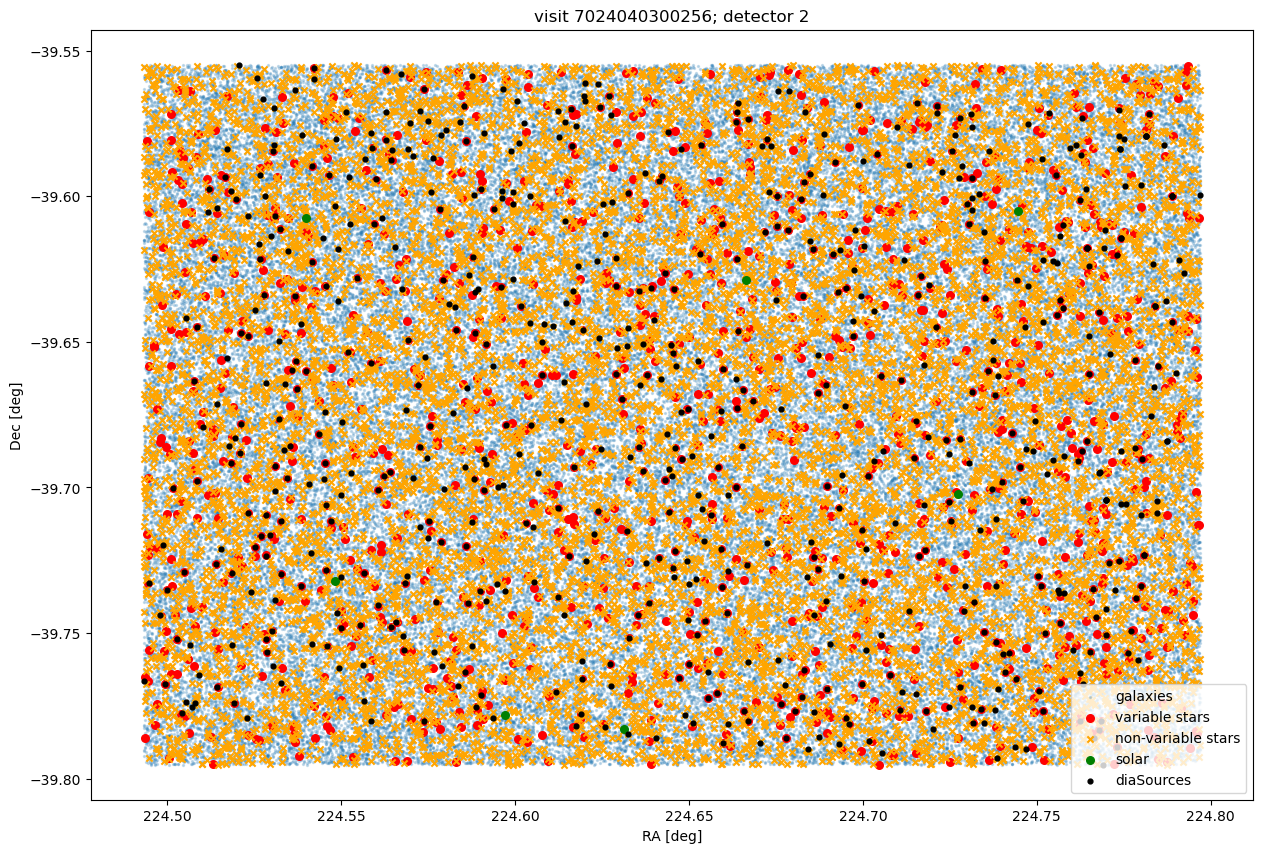

In [36]:
plt.figure(figsize=(15,10))

plt.scatter(df_single_gal_zoom['ra'], df_single_gal_zoom['dec'], s=2, alpha=0.21, label = 'galaxies')
plt.scatter(df_single_ps_var_zoom['ra'], df_single_ps_var_zoom['dec'], s=30, alpha=1, label = 'variable stars', color = 'red', marker='o')
plt.scatter(df_single_ps_no_var_zoom['ra'], df_single_ps_no_var_zoom['dec'], s=20, alpha=1, label = 'non-variable stars', color = 'orange', marker='x')
plt.scatter(df_single_sso_zoom['ra'], df_single_sso_zoom['dec'], s=30, alpha=1, label = 'solar', color ='green')
plt.scatter(src_single_visit_det['ra'], src_single_visit_det['dec'], s=12, alpha=1, label = 'diaSources', color ='black')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.title('visit '+str(visit)+'; detector '+str(detector))
plt.legend()

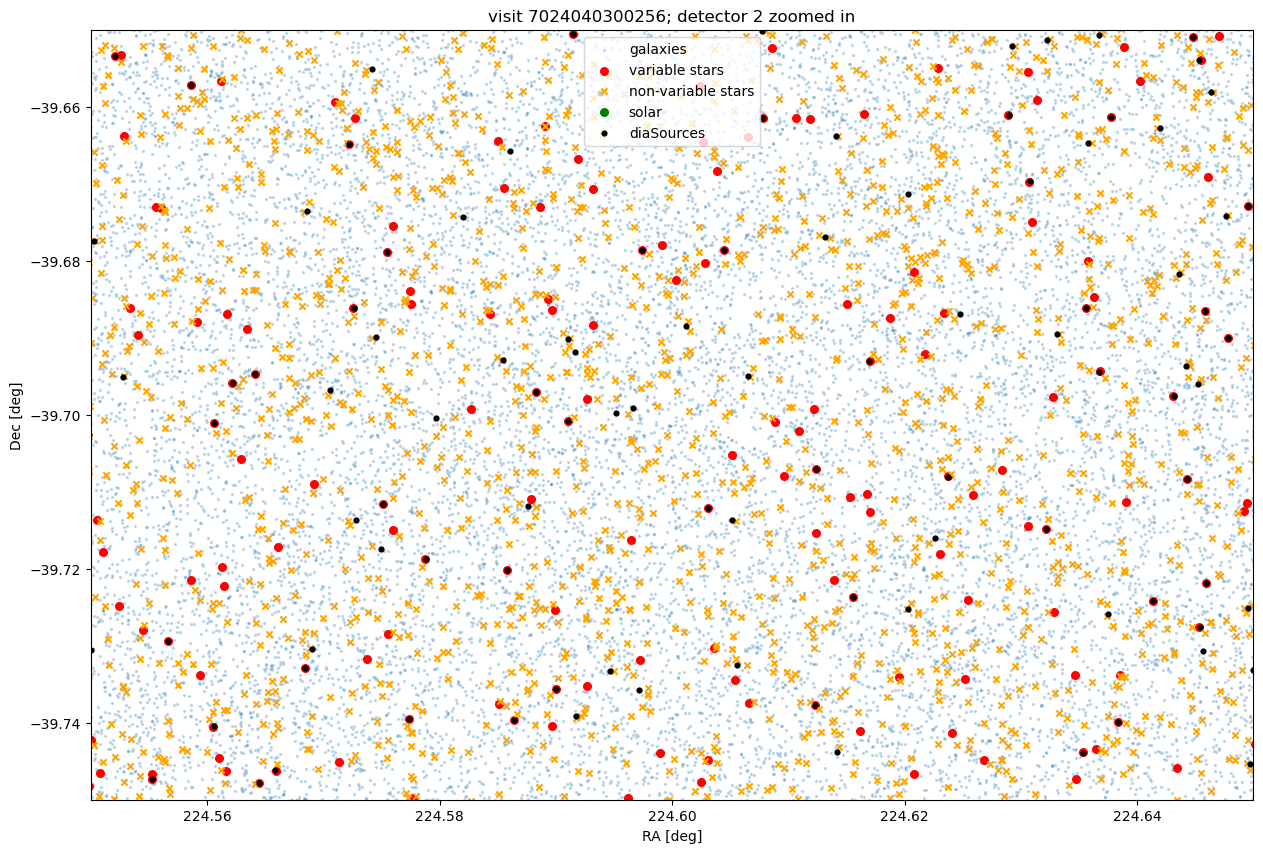

In [37]:
plt.figure(figsize=(15,10))

plt.scatter(df_single_gal_zoom['ra'], df_single_gal_zoom['dec'], s=2, alpha=0.21, label = 'galaxies')
plt.scatter(df_single_ps_var_zoom['ra'], df_single_ps_var_zoom['dec'], s=30, alpha=1, label = 'variable stars', color = 'red', marker='o')
plt.scatter(df_single_ps_no_var_zoom['ra'], df_single_ps_no_var_zoom['dec'], s=20, alpha=1, label = 'non-variable stars', color = 'orange', marker='x')
plt.scatter(df_single_sso_zoom['ra'], df_single_sso_zoom['dec'], s=30, alpha=1, label = 'solar', color ='green')
plt.scatter(src_single_visit_det['ra'], src_single_visit_det['dec'], s=12, alpha=1, label = 'diaSources', color ='black')
plt.legend()
plt.xlim(224.55, 224.65)
plt.ylim(-39.75, -39.65)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.title('visit '+str(visit)+'; detector '+str(detector)+' zoomed in')
plt.legend()

In [13]:
# Possible improvments: 
# cut on magnitude here? example 
# call butler to show the image?
# given diaSource give me everything in the true Table within 1 arcSec? some basic crossmatching - matcher in the stack, association.py, lsst.ap, associations task (see below )

In [ ]:
"""
data_id = {"instrument": instrument, "detector": detector, "visit": visit}
calexp = butler.get("initial_pvi", dataId=data_id, collections=collections)
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')
display1 = afwDisplay.Display(frame=1)
"""

# Matching 

In [ ]:
# goal-  Around each of true variable sources do a small cone search for diaObjects
# result - there are mutliples, but that might be due to failures in the pipeline that has to be restarted

In [65]:
import smatch

nside=4096 # healpix nside
maxmatch=0 # return two closest matches

ra1 = df_single_ps_var_zoom['ra'].values
dec1 = df_single_ps_var_zoom['dec'].values

ra2 = pp_object_table['ra'].values
dec2 = pp_object_table['dec'].values

radius = 1/3600

# ra,dec,radius in degrees
matches = smatch.match(ra1, dec1, radius, ra2, dec2,
                       nside=nside, maxmatch=maxmatch)




In [68]:
unique_values, counts = np.unique(matches['i1'] , return_counts=True)

In [77]:
# number of variable objects to start with
print(len(df_single_ps_var_zoom))
# number of variable objects that have been matched to more than one diaObject
print(np.sum(counts >= 1))
# number of variable objects that have been matched to one and only one diaObject
print(np.sum(counts == 1))
# number of variable objects that have been matched to more than one diaObject
print(np.sum(counts > 1))

1287
783
620
163


In [109]:
163/783

0.2081736909323116

In [110]:
551/1553

0.3547971667739858

In [92]:
#true variables associated to multiple objects
var_mult_obj = df_single_ps_var_zoom.iloc[unique_values[counts > 1]]

sin_ra, sin_dec = var_mult_obj.iloc[100][['ra', 'dec']]

In [98]:
diaObj_single_truObj = pp_object_table[ (pp_object_table['ra'] < sin_ra+1/3600) & (pp_object_table['ra'] > sin_ra-1/3600) & \
    (pp_object_table['dec'] < sin_dec+1/3600) & (pp_object_table['dec'] > sin_dec-1/3600)]
diaObj_single_truObj

,diaObjectId,ra,dec,nDiaSources,validityStart,validityEnd,lastNonForcedSource
79012,3065438941164339624,224.659202,-39.721080,2,2024-05-12 12:26:36.289377,None,2024-05-12 08:17:38.853488
137864,3065473863539229117,224.659256,-39.721014,28,2024-05-13 05:48:50.816378,None,2024-05-10 21:25:32.135859
168289,3065438944385565191,224.659317,-39.721019,8,2024-05-13 01:44:36.564136,None,2024-05-11 04:30:19.730782


In [106]:
diaObjectId1 = diaObj_single_truObj['diaObjectId'].iloc[0]  # Specify the diaObjectId you want to query
with apdbQuery.connection as connection:
    s1_obj = pd.read_sql_query(
        f'''
        SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai",
            "psfFlux", "psfFluxErr", "scienceFlux", "scienceFluxErr", "snr",
             "band"
        FROM "{schema}"."DiaSource"
        WHERE "diaObjectId" = {diaObjectId1}
        LIMIT 3000000;
        ''',
        connection
    )
    
diaObjectId2 = diaObj_single_truObj['diaObjectId'].iloc[1]  # Specify the diaObjectId you want to query
with apdbQuery.connection as connection:
    s2_obj = pd.read_sql_query(
        f'''
        SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai",
            "psfFlux", "psfFluxErr", "scienceFlux", "scienceFluxErr", "snr",
            "band"
        FROM "{schema}"."DiaSource"
        WHERE "diaObjectId" = {diaObjectId2}
        LIMIT 3000000;
        ''',
        connection
    )
    
diaObjectId3 = diaObj_single_truObj['diaObjectId'].iloc[2]  # Specify the diaObjectId you want to query
with apdbQuery.connection as connection:
    s3_obj = pd.read_sql_query(
        f'''
        SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai",
            "psfFlux", "psfFluxErr", "scienceFlux", "scienceFluxErr", "snr",
            "band"
        FROM "{schema}"."DiaSource"
        WHERE "diaObjectId" = {diaObjectId3}
        LIMIT 3000000;
        ''',
        connection
    )

Text(0, 0.5, 'dec [deg]')

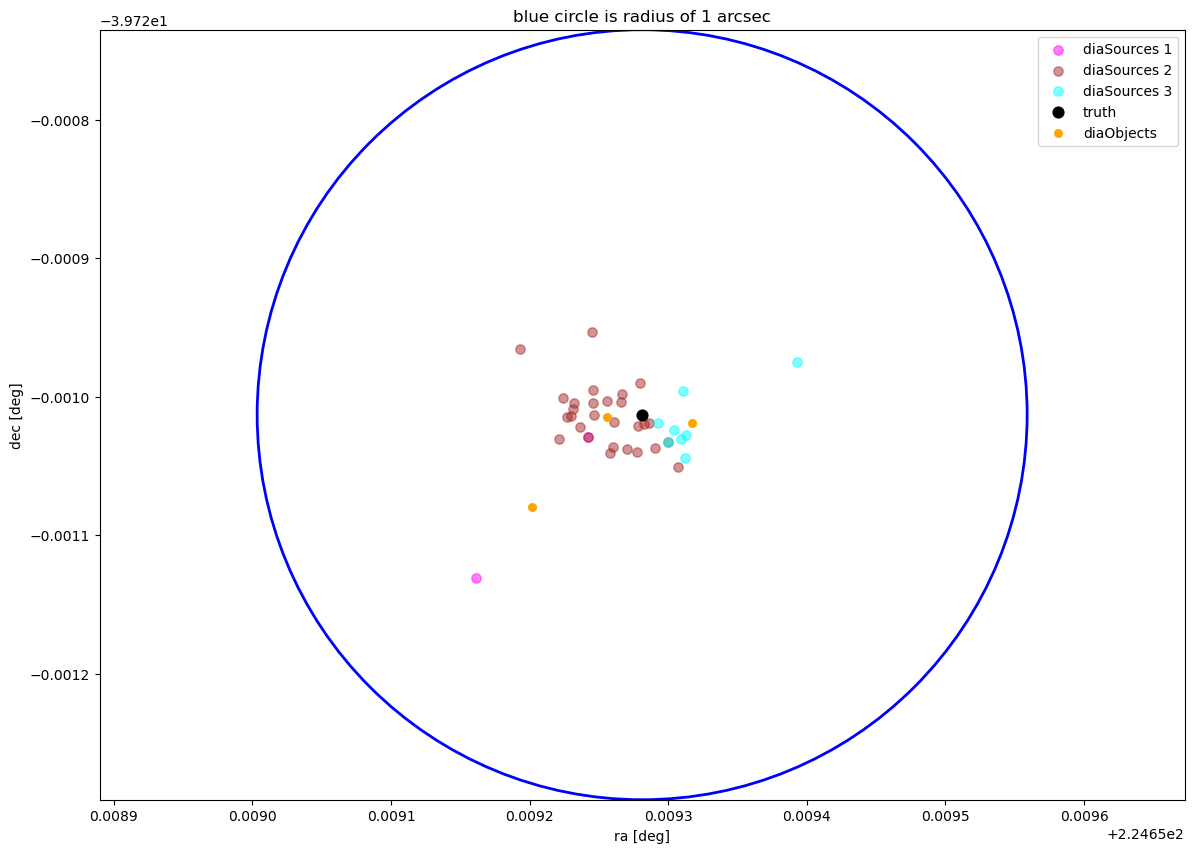

In [108]:
from matplotlib.patches import Circle

plt.figure(figsize = (14,10))

#plt.scatter(matches_close['ra'], matches_close['dec'], s=300, label = 'matched diaObjects', facecolors='none', edgecolors='magenta')
#plt.scatter(matches_close2['ra'], matches_close2['dec'], s=300, label = 'second matched diaObjects', facecolors='none', edgecolors='brown')

# plt.scatter(pp_source_table_latest_one_f['ra'], pp_source_table_latest_one_f['dec'], s=15, color = 'green', label = 'diaSources')


plt.scatter(s1_obj['ra'], s1_obj['dec'], s=45, color = 'magenta', label = 'diaSources 1', alpha=0.5)
plt.scatter(s2_obj['ra'], s2_obj['dec'], s=45, color = 'brown', label = 'diaSources 2', alpha=0.5)
plt.scatter(s3_obj['ra'], s3_obj['dec'], s=45, color = 'cyan', label = 'diaSources 3', alpha=0.5)

plt.scatter(df_single_ps_var['ra'], df_single_ps_var['dec'], s=60, label = 'truth', color = 'black')
plt.scatter(pp_object_table['ra'], pp_object_table['dec'], s=30, color = 'orange', label = 'diaObjects')

plt.legend()
plt.xlim(sin_ra-1/3600, sin_ra+1/3600)
plt.ylim(sin_dec-1/3600, sin_dec+1/3600)

circle = Circle((sin_ra, sin_dec), 1/3600, edgecolor='blue', facecolor='none', linewidth=2)  # Adjust the position and size as needed

current_axes = plt.gca()
current_axes.add_patch(circle)
current_axes.set_aspect('equal', adjustable='datalim')

plt.title('blue circle is radius of 1 arcsec')
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')